# Recipe Recommendation System
Creating, Testing, and Tuning unsupervised learning methods to recommend relevant recipes based on ingredient and category preference

Workflow:
1. Load, aggregate, clean, and tokenize recipe text data
    - Identify Food Recipe Specific stop words that might be useful to ignore (e.g. measurements, numbers)
    - It's likely that recipe attributes will depend heavily on ingredients and cooking methods, not necessarily
    - Think twice about assigning words as stopwords, they might end up being useful.
    - You may want to lemmatize the data to reduce sparseness; check lemmatization process to see if it strips important words, foods, or ingredients. Also, remove punctuation: it won't help for keyword 
2. ~~Create Word Embeddings using Word2Vec or GloVe Models (Consider using pretrained word embeddings)~~
    - Discuss in detail the reason to choose one over the other for this context
    - Setup neural network locally and run remotely on google colab
    - I want to try tfidf and GloVe model, because tfidf doesn't take into account the order of words, which is isn't such a problem with recipes - it's the ingredients and cooking techniques that matter more. However, GloVe word vectors may be able to produce new words outside of the corpora text when summarizing the documents
3. Compare Topic Extraction Methods
    - ~~LDA2Vec~~
    - LDA
    - NNMF
4. Generate keywords using keyword summarization and textrank
    - Create methodology selectively assigns generated categories (e.g. LSA/NNMF Score must be above certain score threshold)
    - Define metrics that evaluate the validity, breadth, and descriptive value of the assigned categories
    - Identify Food Recipe Specific stop words that passed that might be suitable in the filter.
5. Create extra features useful for search result ranking
    - ~~Difficulty (Time, Number of Ingredients, Servings (inverse relationship),~~
    - Import Unsupervised Generated Categories
    - Create ratings that calculate overall weight.
6. Find similarity scoring methods that would work best in this context. Some variation of Cosine Similarity will work best
7. Create algorithm that utilizes similarity to sort recipes based on user-inputted queries, and sort base on other features as well.

-----

Regarding the Available Recipe Images

Around 70,000 recipes out of the 125,000 have corresponding images, so it's possible to utilize these images to improve the models or create seperate, supplementary model

Ideas:
- Training a neural network to identify/predict/generate categories of foods based on their images


### The Data
Although I can no longer find the direct download, the link and code for the scraper the original user used to collect the data set is [here](https://github.com/rtlee9/recipe-box). This user collected the title, ingredients, and instructions from recipes found on Allrecipes.com, epicurious.com, and foodnetwork.com.

For this project, the data was directly downloaded and uploaded for the creation of my own model. All the code present are of my own creation or significantly modified from the Thinkful curriculum. No other software sources were used verbatim within this project.

In [1]:
import pandas as pd
import numpy as np
import re
import spacy

In [2]:
allrecipes_raw = pd.read_json('recipes_raw_nosource_ar.json')

In [3]:
allrecipes = allrecipes_raw.copy().T.reset_index().drop(columns = ['index'])
allrecipes.head(1)

,title,ingredients,instructions,picture_link
0,Slow Cooker Chicken and Dumplings,"[4 skinless, boneless chicken breast halves AD...","Place the chicken, butter, soup, and onion in ...",55lznCYBbs2mT8BTx6BTkLhynGHzM.S


In [6]:
recipes = pd.concat([allrecipes, epicurious, foodnetwork]).reset_index(drop=True) # Concat does not reset indices
recipes.shape

(125164, 4)

In [7]:
# Count of missing values by category
recipes.isna().sum()

title             569
ingredients       517
instructions      691
picture_link    42571
dtype: int64

In [8]:
# Number recipes/rows that have any missing values besides missing pictures
null_recs = recipes.copy().drop(columns = 'picture_link').T.isna().any()
null_recs.sum()

691

In [9]:
recipes[null_recs].head()

,title,ingredients,instructions,picture_link
5874,NaN,NaN,NaN,NaN
15020,NaN,NaN,NaN,NaN
15023,NaN,NaN,NaN,NaN
15025,NaN,NaN,NaN,NaN
15637,NaN,NaN,NaN,NaN


In [10]:
rows_to_drop = recipes[null_recs].index
recipes = recipes.drop(index = rows_to_drop).reset_index(drop = True)
recipes.shape

(124473, 4)

In [11]:
recipes.dtypes

title           object
ingredients     object
instructions    object
picture_link    object
dtype: object

In [12]:
# Indexing rows with columns that only contain numbers or punctuation
import string
nc_ingred_index = [index for i, index in zip(recipes['ingredients'], recipes.index) if all(j.isdigit() or j in string.punctuation for j in i)]
nc_title_index = [index for i, index in zip(recipes['title'], recipes.index) if all(j.isdigit() or j in string.punctuation for j in i)]
nc_instr_index = [index for i, index in zip(recipes['instructions'], recipes.index) if all(j.isdigit() or j in string.punctuation for j in i)]


In [13]:
# Checking number of rows in each category that are only punc/nums
index_list = [nc_ingred_index, nc_title_index, nc_instr_index]
[len(x) for x in index_list]

[1520, 0, 39]

In [14]:
# generating unique indices for index_list and dropping from dataframe
# recipes without recipe instructions or ingredients are not useable
from functools import reduce
from operator import add
inds_to_drop = set(reduce(add, index_list))
print(len(inds_to_drop))
recipes = recipes.drop(index=inds_to_drop).reset_index(drop=True)
recipes.shape

1551


(122922, 4)

In [15]:
# Recipe instructions with less than 20 characters are not good recipes
empty_instr_ind = [index for i, index in zip(recipes['instructions'], recipes.index) if len(i) < 20]
recipes = recipes.drop(index = empty_instr_ind).reset_index(drop=True)

In [16]:
recipes.shape

(122911, 4)

In [17]:
recipes.isna().sum()

title               0
ingredients         0
instructions        0
picture_link    41687
dtype: int64

In [18]:
# Checking for low ingredient recipes.
#low_ingr_ind = [index for i, index in zip(recipes['ingredients'], recipes.index) if len(i) < 20]
low_ingr_index = [index for i, index in zip(recipes['ingredients'], recipes.index) if i[0] == np.nan]
len(low_ingr_index)
recipes.loc[low_ingr_index, 'ingredients']

Series([], Name: ingredients, dtype: object)

In [19]:
# Searching for pseudo empty lists
[index for i, index in zip(recipes['ingredients'], recipes.index) if np.nan in recipes.loc[index,'ingredients']]


[]

### Cleaning to Prepare for Tokenizing

Cleaning Specifics:
- Removing ADVERTISEMENT
- Pruning dataset of rows with empty cells or inadequate recipes
- Remove all punctuation, digits, and extraneous spacing

In [20]:
# Removing ADVERTISEMENT text from ingredients list
ingredients = []
for ing_list in recipes['ingredients']:
    clean_ings = [ing.replace('ADVERTISEMENT','').strip() for ing in ing_list]
    if '' in clean_ings:
        clean_ings.remove('')
    ingredients.append(clean_ings)
recipes['ingredients'] = ingredients

In [21]:
recipes.loc[0,'ingredients']

['4 skinless, boneless chicken breast halves',
 '2 tablespoons butter',
 '2 (10.75 ounce) cans condensed cream of chicken soup',
 '1 onion, finely diced',
 '2 (10 ounce) packages refrigerated biscuit dough, torn into pieces']

In [22]:
# Extracting ingredients from their lists and formatting as single strings
recipes['ingredient_text'] = ['; '.join(ingredients) for ingredients in recipes['ingredients']]
recipes['ingredient_text'].head()


0    4 skinless, boneless chicken breast halves; 2 ...
1    2 (10.75 ounce) cans condensed cream of mushro...
2    1/2 cup packed brown sugar; 1/2 cup ketchup; 1...
3    1 cup butter, softened; 1 cup white sugar; 1 c...
4    8 ounces whole wheat rotini pasta; 3 cups fres...
Name: ingredient_text, dtype: object

In [23]:
# Counting the number of ingredients used in each recipe
recipes['ingredient_count'] = [len(ingredients) for ingredients in recipes['ingredients']]

In [24]:
recipes.head(1)

,title,ingredients,instructions,picture_link,ingredient_text,ingredient_count
0,Slow Cooker Chicken and Dumplings,"[4 skinless, boneless chicken breast halves, 2...","Place the chicken, butter, soup, and onion in ...",55lznCYBbs2mT8BTx6BTkLhynGHzM.S,"4 skinless, boneless chicken breast halves; 2 ...",5


In [25]:
all_text = recipes['title'] + ' ' + recipes['ingredient_text'] + ' ' + recipes['instructions']
all_text[0]

'Slow Cooker Chicken and Dumplings 4 skinless, boneless chicken breast halves; 2 tablespoons butter; 2 (10.75 ounce) cans condensed cream of chicken soup; 1 onion, finely diced; 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.\nCover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.\n'

In [26]:
# Clean_text Function
import string
import re

def clean_text(documents):
    cleaned_text = []
    for doc in documents:
        doc = doc.translate(str.maketrans('', '', string.punctuation)) # Remove Punctuation
        doc = re.sub(r'\d+', '', doc) # Remove Digits
        doc = doc.replace('\n',' ') # Remove New Lines
        doc = doc.strip() # Remove Leading White Space
        doc = re.sub(' +', ' ', doc) # Remove multiple white spaces
        cleaned_text.append(doc)
    return cleaned_text

# Cleaning Text
cleaned_text = clean_text(all_text)

In [27]:
cleaned_text[2]

'Brown Sugar Meatloaf cup packed brown sugar cup ketchup pounds lean ground beef cup milk eggs teaspoons salt teaspoon ground black pepper small onion chopped teaspoon ground ginger cup finely crushed saltine cracker crumbs Preheat oven to degrees F degrees C Lightly grease a x inch loaf pan Press the brown sugar in the bottom of the prepared loaf pan and spread the ketchup over the sugar In a mixing bowl mix thoroughly all remaining ingredients and shape into a loaf Place on top of the ketchup Bake in preheated oven for hour or until juices are clear'

### Tokenizing Using Spacy

For this tokenization, we will lemmatize the words. This is will help create a denser word embeddings. However, no POS tagging, know entities, or noun_phrases will be parsed and added.

In [28]:
# Testing Strategies and Code
nlp = spacy.load("en_core_web_sm")
' '.join([token.lemma_ for token in nlp(cleaned_text[2]) if not token.is_stop])

'Brown Sugar Meatloaf cup pack brown sugar cup ketchup pound lean ground beef cup milk egg teaspoon salt teaspoon grind black pepper small onion chop teaspoon ground ginger cup finely crush saltine cracker crumb Preheat oven degree F degree C lightly grease x inch loaf pan Press brown sugar prepared loaf pan spread ketchup sugar mix bowl mix thoroughly remain ingredient shape loaf Place ketchup Bake preheat oven hour juice clear'

My current strategy is to strip down the text as much as possible. In this case that means lemmatizing words and removing stop words. The goal here is not text prediction, but similarity measures and keyword extraction, which don't require the semantic granularity that stop words and non-lemmatized words might provide.

In [29]:
# Tokenizing Function that lemmatizes words and removes Stop Words
def text_tokenizer(documents):
    tokenized_documents = []
    for doc in documents:
        tok_doc = ' '.join([token.lemma_ for token in nlp(doc) if not token.is_stop])
        tokenized_documents.append(tok_doc)
    return tokenized_documents

In [30]:
# Tokenizing Function to run in parallel
def text_tokenizer_mp(doc):
    tok_doc = ' '.join([token.lemma_ for token in nlp(doc) if not token.is_stop])
    return tok_doc

In [31]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  8


In [ ]:
# Parallelzing tokenizing process
pool = mp.Pool(mp.cpu_count())
tokenized_text = pool.map(text_tokenizer_mp, [doc for doc in cleaned_text])

In [ ]:
from tqdm import tqdm

pool = mp.Pool(mp.cpu_count())

# Use tqdm to wrap around the map function to add a progress bar
tokenized_text = list(tqdm(pool.imap(text_tokenizer_mp, [doc for doc in cleaned_text]), total=len(cleaned_text)))

In [32]:
import concurrent.futures
from tqdm import tqdm


# Use concurrent.futures to create a ThreadPoolExecutor
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Map the function over the documents and wrap with tqdm for progress bar
    tokenized_text = list(tqdm(executor.map(text_tokenizer_mp, cleaned_text), total=len(cleaned_text)))


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122911/122911 [35:16<00:00, 58.07it/s]


In [33]:
# Save the tokenized_text variable as a csv in order to return to it;
# Do not attempt to run the parser above, it will simply take too long
# Reload the csv from file insted
pd.Series(tokenized_text).to_csv('tokenized_text.csv')

In [34]:
tokenized_text[0]

'Slow Cooker Chicken Dumplings skinless boneless chicken breast half tablespoon butter ounce can condense cream chicken soup onion finely dice ounce package refrigerate biscuit dough tear piece place chicken butter soup onion slow cooker fill water cover Cover cook hour High minute serve place tear biscuit dough slow cooker Cook dough long raw center'

### Creating Word Embeddings

- TF-IDF
- Pre-trained GloVe Word Embeddings
- GloVe Embeddings trained on the recipe corpora

In an attempt to create dense word embeddings, I could find no reliable examples to follow that integrate GloVe or Word2Vec with document topic modeling.

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(lowercase = True,
                            ngram_range = (1,1))

text_tfidf = vectorizer.fit_transform(tokenized_text)
tfidf_words = vectorizer.get_feature_names()
print(text_tfidf.shape)
print(len(tfidf_words))

(122911, 49793)
49793


D:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Topic Modeling
- LDA
- NNMF

The ultimate goal with topic modeling is to group documents together and generate category words using TextRank. These category words can then be used to further refine the recommendation query

------

LDA and NNMF extract topic models by finding similar subgroups of text within the corpora of recipes (or other text documents). However

In [36]:
text_tfidf.shape

(122911, 49793)

In [37]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_components = 50,
          n_jobs = -1,
          max_iter = 100)
text_lda = lda.fit_transform(text_tfidf)
text_lda.shape

(122911, 50)

In [39]:
from sklearn.decomposition import NMF

nmf = NMF(alpha=0.0,
         init='nndsvdar',
         l1_ratio=0.0,
         max_iter = 100,
         n_components = 50,
         solver='cd')

text_nmf = nmf.fit_transform(text_tfidf)
text_nmf.shape

D:\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


(122911, 50)

Models were arbitrarily set to 50 topics. Unfortunately, neither NNMF nor LDA have the ability to calculate the percentage of variance that they capture from the original tfidf matrix. So 50 topics is purely a shot in the dark.

Next Steps:
1. Document x Topic Matrix
2. Word x Topic Matrix

## Exploring Topics by Document

In [40]:
# variable dependencies:
text_series = pd.Series(all_text)

def docs_by_tops(top_mat, topic_range = (0,0), doc_range = (0,2)):
    for i in range(topic_range[0], topic_range[1]):
        topic_scores = pd.Series(top_mat[:,i])
        doc_index = topic_scores.sort_values(ascending = False)[doc_range[0]:doc_range[1]].index
        for j, index in enumerate(doc_index, doc_range[0]):
            print('Topic #{}'.format(i),
                  '\nDocument #{}'.format(j),
                  '\nTopic Score: {}\n\n'.format(topic_scores[index]),
                  text_series[index], '\n\n')

In [41]:
docs_by_tops(text_lda,(0,3),(0,3))

Topic #0 
Document #0 
Topic Score: 0.9178869056235167

 Mushroom Fricassee with Creamy Polenta 6 tablespoons plus 1 teaspoon extra-virgin olive oil; 4 medium shallots, halved and thinly sliced lengthwise; Kosher salt; 10 ounces mixed domestic and wild mushrooms, sliced or cut into bite-sized pieces (about 4 cups); 2 sprigs fresh thyme; 2 cups Chicken Reduction, plus more as needed, recipe follows; 1 tablespoon preserved black truffles, optional; 1 tablespoon chopped fresh chives; Pinch of crushed red pepper; 3 cups Creamy Polenta, recipe follows; 6 pounds chicken bones (some meat on them is fine); 3 tablespoons olive oil; 2 sprigs fresh rosemary, bruised with the dull side of a chef's knife; 1 clove garlic, coarsely chopped; 2 celery stalks, coarsely chopped; 1 medium onion, coarsely chopped; 1 carrot, coarsely chopped; 4 whole canned tomatoes, coarsely chopped; 2 cups dry white wine; 4 cups heavy cream; 4 cups whole milk; 1 tablespoon kosher salt; 1 cup coarse polenta; 4 tablespoons 

In [42]:
docs_by_tops(text_nmf,(0,3),(0,3))

Topic #0 
Document #0 
Topic Score: 0.0324239576703085

 Black Olive Spread 1 (10 ounce) can black olives; 3 tablespoons freshly grated Parmesan cheese; 1 clove garlic, chopped; 1 tablespoon extra virgin olive oil Place olives, Parmesan cheese, and garlic (if using) in a food processor. Add olive oil slowly while running. Process until smooth.
 


Topic #0 
Document #1 
Topic Score: 0.031130205619076996

 Roasted-Garlic Oil  6 large garlic cloves, peeled, halved; 1 tablespoon olive oil; 1 cup extra-virgin olive oil Preheat oven to 350°F. Place garlic cloves and 1 tablespoon olive oil in small ovenproof skillet; stir to coat. Roast in oven until garlic is just golden, shaking pan occasionally, about 15 minutes. Add extra-virgin olive oil; cool in skillet. Transfer oil and garlic to jar. Seal tightly; store in refrigerator up to 2 weeks (keep garlic in oil for flavor and looks, but use only oil in recipes).
Preheat oven to 350°F. Place garlic cloves and 1 tablespoon olive oil in small ov

In [43]:
docs_by_tops(text_nmf,(1,2),(90000,90001))

Topic #1 
Document #90000 
Topic Score: 0.0

 Seitan Flares  1 pound seitan, torn or cut into chunks large enough to fit loosely on the grill grate, or skewered; Extra-virgin olive oil; 1/4 cup of your favorite hot sauce, Frank's Red Hot Cayenne Pepper Sauce preferred; 3 tablespoons pure maple syrup; 1/4 cup freshly squeezed lime juice; 1/2 teaspoon salt; Ground cayenne pepper (the more, the hotter!); 2 tablespoons chopped fresh oregano (optional) Heat the grill to medium-high. Prepare the seitan: Marinate the seitan in the olive oil to cover for 1 hour. Grill the seitan until lightly browned, 3 to 5 minutes or longer, turning often. Transfer to a bowl. Meanwhile, make the sauce, if using: In a glass measure, whisk together the hot sauce, maple syrup, lime juice, salt, and cayenne pepper to taste. Microwave the mixture for 1 minute or until fairly hot, or whisk the mixture together in a small saucepan and place it over direct heat on the grill until it is hot, 4 to 5 minutes, or longer

### Exploring Topics by words

In [44]:
text_nmf.shape

(122911, 50)

In [45]:
text_tfidf.T.shape

(49793, 122911)

In [46]:
# Function for best topic words using cosine similarity
# Variable Dependency:
word_series = pd.Series(tfidf_words)

def words_by_tops(tfidf_mat, top_mat, topic_range=(0,0), n_words=10):
    topic_word_scores = tfidf_mat.T * top_mat
    for i in range(topic_range[0],topic_range[1]):
        word_scores = pd.Series(topic_word_scores[:,i])
        word_index = word_scores.sort_values(ascending = False)[:n_words].index
        print('\nTopic #{}'.format(i))
        for index in word_index:
            print(word_series[index],'\t\t', word_scores[index])

In [47]:
# Keywords using LDA
words_by_tops(text_tfidf, text_lda, (0,3), 10)


Topic #0
add 		 734.0362691984005
heat 		 692.5046909294416
chicken 		 685.2526945568399
minute 		 598.7594257809909
pepper 		 583.7095106972351
cup 		 572.1528301663466
cook 		 558.6591791455244
onion 		 506.8448979019633
salt 		 502.02809606818414
tablespoon 		 478.29238563168565

Topic #1
asparagus 		 39.97122640413298
cup 		 29.009231940358276
pepper 		 23.171334318100513
salt 		 21.980391016311735
minute 		 21.087024760679302
tablespoon 		 20.996229375431298
oil 		 20.94419646103796
teaspoon 		 19.174414364530733
heat 		 18.83849408407568
add 		 18.28926658254095

Topic #2
jar 		 56.603310864281205
cup 		 36.35988365822209
water 		 29.516557137533823
sugar 		 27.255009920684877
lid 		 25.307188908492293
minute 		 24.12999061943288
pepper 		 23.536051617355998
teaspoon 		 22.206176756377282
salt 		 21.997607924075204
heat 		 21.82763458172198


In [48]:
# Words using NMF
words_by_tops(text_tfidf, text_nmf, (0,3), 10)


Topic #0
oil 		 28.19700597439011
olive 		 23.915625065117847
pepper 		 23.50711571121119
garlic 		 21.58086711651612
salt 		 19.28267091731731
cup 		 18.346383087831125
tablespoon 		 18.124691159467904
add 		 16.753147511483427
chop 		 16.042031691504846
heat 		 15.403578097142859

Topic #1
cup 		 81.46874370062099
flour 		 76.70742475668544
sugar 		 69.7242364611337
bake 		 65.96442325204444
teaspoon 		 53.145675033695284
egg 		 47.116932803280385
butter 		 46.925469301468645
vanilla 		 41.55810562679816
degree 		 41.49717654567342
soda 		 36.94078380629167

Topic #2
chicken 		 132.12901067494755
breast 		 29.634174262388022
pepper 		 28.874856128304117
cup 		 27.13921894104644
heat 		 25.08875148188066
minute 		 24.910876906732618
cook 		 24.529563792206964
oil 		 23.709216412831832
tablespoon 		 22.799620309566496
sauce 		 21.446329614105302


Ultimately, in looking at the first three topic documents for LDA and NNMF, it appears that NNMF made more distinct topic models: 0. Spreads, 1. Cakes 2. Chicken.

LDA on the other made two good topics 0. Salads and 1. Gravies. The third topic, I am unable to tell what it's clustering on. Therefore, we will proceed with NNMF topics to generate

### Keyword Extraction of Topics Using TextRank

The purpose of using TextRank to extract keywords 

------------

Consider using a smaller corpora size, so as to more quickly code. Then run the entire copora.
Using the time module to test out corpora sizes.

Using TextRank to summarize the topics by extracting words involves many variables:
- Deciding how many of the top documents each the topic should be summarized?
    - Arbitrarily: top 100, evaluate, then only decrease from there.
- Should TextRank then be performed once over the selected topic corpora, or should it be run individually and then scores added to make an aggregated rank?
    - For the sake of simplicity it should probably only be run over the entire corpora
- How many top ranked words should be used?
    - Check out the top ranks words first, then decide.
    - Arbitrarily choosing the top 20 ranked
- Then once keywords are decided, to how many documents should those words be assigned the extract?
    - I think it depends on the number of documents used to find the categorical keywords.
- Once we're satisfied with a TextRank strategy, we need to this about which method to use to extract topics (NNMF, LDA) as well as whether we'll NNMF, LDA, or TextRank to extract keywords.

In [49]:
# Pulling the top one-hundred documents ranked in similarity among Topic #1
text_index = pd.Series(text_nmf[:,1]).sort_values(ascending = False)[:100].index
text_4summary = pd.Series(cleaned_text)[text_index]

# Manually Creating a list of recipe stop
recipe_stopwords = ['cup','cups','ingredient','ingredients','teaspoon','tablespoon','oven']


Because recipes are a very niche subject matter within NLP, it's likely that there are no list of stopwords related to this domain. The above 'recipe_stopwords' will thus be manually updated as necessary.

In [50]:
# generating topic filter
import time
start_time = time.time()

parsed_texts = nlp(' '.join(text_4summary)) 
kw_filts = set([str(word) for word in parsed_texts 
                if (word.pos_== ('NOUN' or 'ADJ' or 'VERB'))
                and str(word) not in recipe_stopwords])

print('Execution Time: {} seconds', time.time() - start_time)


Execution Time: {} seconds 2.0621414184570312


In [65]:
# Creating adjecency Table for recipes.
adjacency = pd.DataFrame(columns=kw_filts, index=kw_filts, data = 0)
for i, word in enumerate(parsed_texts):
    if any ([str(word) == item for item in kw_filts]):
        end = min(len(parsed_texts), i+5) # Window of four words
        nextwords = parsed_texts[i+1:end]
        inset = [str(x) in kw_filts for x in nextwords]
        neighbors = [str(nextwords[i]) for i in range(len(nextwords)) if inset[i]]
        if neighbors:
            adjacency.loc[str(word), neighbors] += 1

C:\Users\preet\AppData\Local\Temp\ipykernel_14140\14376556.py:14: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  adjacency.loc[str(word), neighbors] += 1


ValueError: cannot reindex on an axis with duplicate labels

In [69]:
from collections import defaultdict

# Ensure unique keywords
kw_filts = list(set(kw_filts))

# Create a defaultdict to store counts of keyword pairs
adjacency_dict = defaultdict(lambda: defaultdict(int))

# Iterate over parsed_texts to populate the adjacency_dict
for i, word in enumerate(parsed_texts):
    if str(word) in kw_filts:
        end = min(len(parsed_texts), i + 5)  # Window of five words
        nextwords = parsed_texts[i + 1:end]
        neighbors = [str(nextword) for nextword in nextwords if str(nextword) in kw_filts]
        if neighbors:
            for neighbor in neighbors:
                adjacency_dict[str(word)][neighbor] += 1

# Create DataFrame from adjacency_dict
adjacency = pd.DataFrame(adjacency_dict).fillna(0)

# Ensure that all keywords are present in both index and columns
adjacency = adjacency.reindex(index=kw_filts, columns=kw_filts).fillna(0)

print(adjacency)

             remainder  consistency  grapeseed  room  package  Whisk  top  \
remainder          0.0          0.0        0.0   0.0      0.0    0.0  0.0   
consistency        0.0          0.0        0.0   0.0      0.0    0.0  0.0   
grapeseed          0.0          0.0        0.0   0.0      0.0    0.0  0.0   
room               0.0          0.0        0.0   0.0      0.0    0.0  0.0   
package            0.0          0.0        0.0   0.0      0.0    0.0  0.0   
...                ...          ...        ...   ...      ...    ...  ...   
chill              0.0          0.0        0.0   0.0      0.0    0.0  0.0   
well               0.0          0.0        0.0   0.0      0.0    0.0  0.0   
powder             0.0          0.0        0.0   0.0      0.0    1.0  0.0   
spatula            0.0          0.0        0.0   0.0      0.0    0.0  0.0   
light              0.0          0.0        0.0   0.0      0.0    0.0  0.0   

             foil  sand  ounces  ...  syrup  bread  maple  coloring  hour  

For the sake of implementing a simple TextRank precedure, all of the recipes were concatenated into one continuous corpora. The issue with this is that in tabulating the word adjacencies there is no delineation between one recipe and the next. So the neighbors at the tail ends of any one recipe are considered neighbors to the words at the front end of the next corresponding recipe. However, while this does generate false word adjacencies, the recipes are ordered by topic rank so that that adjacent recipes are in content. In theory, this dampens the effect, if any, that the false word adjacencies might create.

In [70]:
import networkx as nx

# Running TextRank
nx_words = nx.from_numpy_matrix(adjacency.values)
ranks=nx.pagerank(nx_words, alpha=.85, tol=.00000001)

# Identifying the most highly ranked keywords
ranked = sorted(((ranks[i],s) for i,s in enumerate(kw_filts)),
                reverse=True)

In [71]:
ranked[:25]

[(0.05643619458811701, 'flour'),
 (0.045061545107377074, 'baking'),
 (0.03742601317374986, 'sugar'),
 (0.026188159539610324, 'powder'),
 (0.02318777741261558, 'mixture'),
 (0.022481324589279365, 'vanilla'),
 (0.019771137474108115, 'salt'),
 (0.019536431613809666, 'teaspoons'),
 (0.01910718228251914, 'eggs'),
 (0.018420382489602934, 'degrees'),
 (0.01839114085699566, 'batter'),
 (0.017964706756475324, 'pan'),
 (0.017742971030785315, 'bowl'),
 (0.017329475243209144, 'extract'),
 (0.01694593382002486, 'butter'),
 (0.01666605253764377, 'soda'),
 (0.013196884729024829, 'cinnamon'),
 (0.012563083141587331, 'oil'),
 (0.012355973435932846, 'muffin'),
 (0.011809551330689566, 'inch'),
 (0.011509322091712933, 'minutes'),
 (0.011061364188794364, 'Stir'),
 (0.010821395495893948, 'egg'),
 (0.01073743970163366, 'Mix'),
 (0.010007124926054189, 'C')]

In [72]:
adjacency.shape

(242, 242)

In [73]:
# checking to see there are actual values loaded in the adjacency df
import scipy
scipy.sparse.csr_matrix(adjacency.copy().values)

<242x242 sparse matrix of type '<class 'numpy.float64'>'
	with 2539 stored elements in Compressed Sparse Row format>

Looking just at the top ranked keywords for the Topic \#1 documents, one would guess that the topic that was clustered is baked cakes. The top ranked word is 'baking' which is spot on! Unfortunately, because we used tf-idf, there is no way of calculating from these keywords a sort of categorical vector mapping such as 'baking'. If we were to use some sort of word embeddings such as Word2Vec or GloVe then we might be able to calculate abstract summaries of these words.

However, these keyword extractions are still useful insofar that the queries will match indidrectly to the the umbrella topic of 'baking' if those queries still match with the words extracted from the baking topic.

For now, we will arbitratily choose between text rank and nnmf word topic ranks to generate keywords. TextRank is a clear winner over mere text cosine similarity ranks in the case of this topic, so we will proceed with using TextRank as the categories. 

In [74]:
len(kw_filts)

242

In [75]:
pd.Series(list(kw_filts)).nunique()

242

In [76]:
text_4summary[3060]

'Blueberry Buttermilk Coffeecake cup butter cups white sugar eggs teaspoon vanilla extract cups buttermilk cups allpurpose flour teaspoons baking powder teaspoon baking soda teaspoon salt cups blueberries cup allpurpose flour cup white sugar tablespoons butter softened Preheat oven to degrees F degrees C Grease and flour a x inch pan Sift together cups flour baking powder baking soda and salt Set aside In a large bowl cream together cup butter and cup sugar until light and fluffy Beat in the eggs one at a time then stir in the vanilla Beat in the flour mixture alternately with the buttermilk mixing just until incorporated Sir in blueberries Pour batter into prepared pan In a small bowl combine cup flour and cup sugar cut in tablespoons butter until mixture resembles coarse crumbs Sprinkle over top of batter Bake in the preheated oven for to minutes or until a toothpick inserted into the center of the cake comes out clean Allow to cool'

Exploration of TextRank Takeaways: 
- All of the filter keyword are pretty similar because they were all extracted from the top 100 recipes within their topic.
- Recipes NLP stopwords need to be compiled
- The keywords that TextRank extracts relate really well to the underlying extracted topic, however, there's no way of abstractively generating semantically similar words that collectively captures the essence of the topic
- False adjacencies are created but the produced keywords do not look dissimilar from the topic modelled words using NNMF.
- One downside of using TextRank is that upon inspection of the ranked words and the filter words, it appears multiple copies of the same words are not getting identified as unique, such that, for example, there will be multiple copies of 'toothpick' or 'cups' with different individual rankings.



### Analyzing Score distribution of document and word ranks within Topics
The purpose is to visualize the distribution of document topic rankings and decide the cutoff for the documents that associate most with that topic.

In [77]:
import matplotlib.pyplot as plt
# text_lda
# text_nmf
# ranked

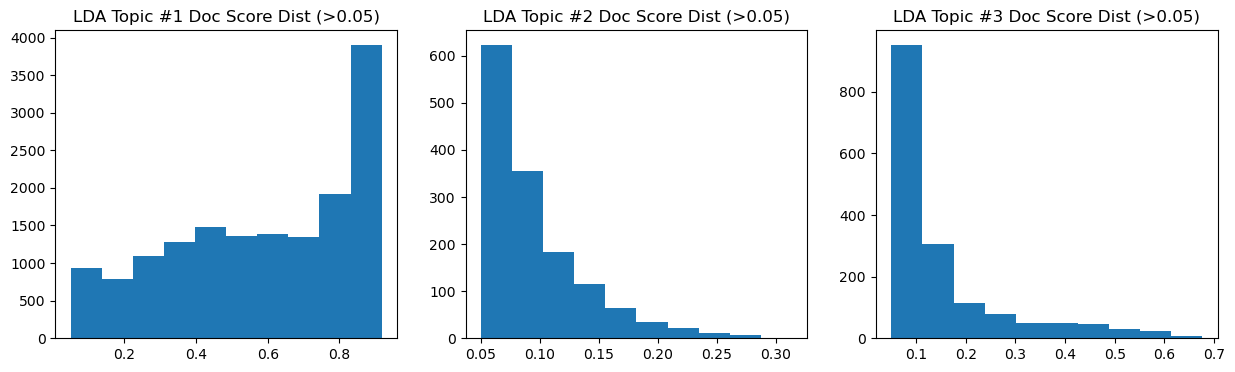

In [78]:
# LDA Topic documents for topics 0-2
plt.figure(figsize=(15,4))
for i in range(3):
    series = pd.Series(text_lda[:,i])
    plt.subplot(1,3,i+1)
    plt.hist(series[series > 0.05])
    plt.title('LDA Topic #{} Doc Score Dist (>0.05)'.format(i+1))
plt.show()

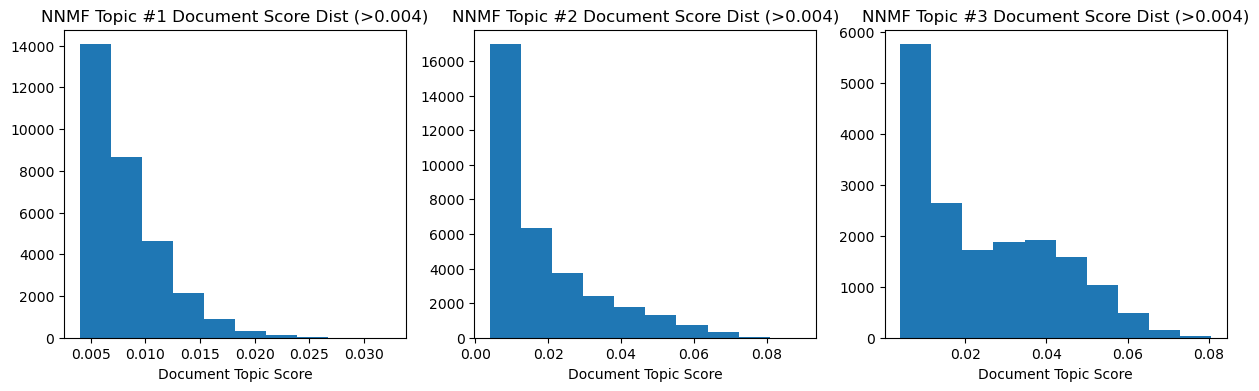

In [79]:
# NNMF Topic documents for topics 0-2
plt.figure(figsize=(15,4))
for i in range(3):
    series = pd.Series(text_nmf[:,i])
    plt.subplot(1,3,i+1)
    plt.hist(series[series > 0.004])
    plt.title('NNMF Topic #{} Document Score Dist (>0.004)'.format(i+1))
    plt.xlabel('Document Topic Score')
#plt.savefig('DocsByTop_Score_Distributions.png', transparent = True)
plt.show()

Based on the first three topics for LDA and NNMF, I will subjectly choose the top 1500-2000 documents. This number of documents seems to be where the loadings for each score distibution either level off or spike upward (an elbow so to speak).

Confirming with Topic \#1 of the NNMF topics, the baking topic, baking recipes extended as far as 10,000 of the top ranked recipes within that category.

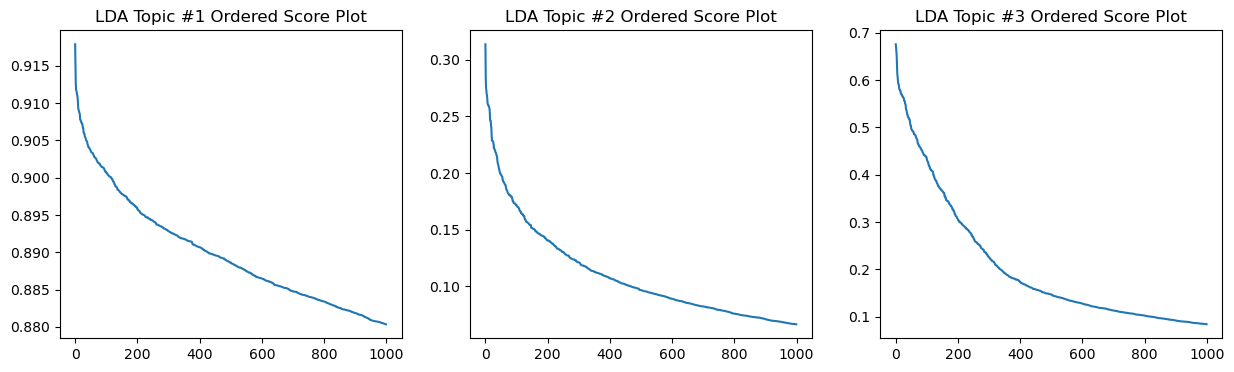

In [80]:
# LDA Topic document scores for topics 0-2
plt.figure(figsize=(15,4))
for i in range(3):
    series = pd.Series(text_lda[:,i]).copy().sort_values(ascending = False).reset_index(drop = True)
    plt.subplot(1,3,i+1)
    plt.plot(series[:1000])
    plt.title('LDA Topic #{} Ordered Score Plot'.format(i+1))
plt.show()

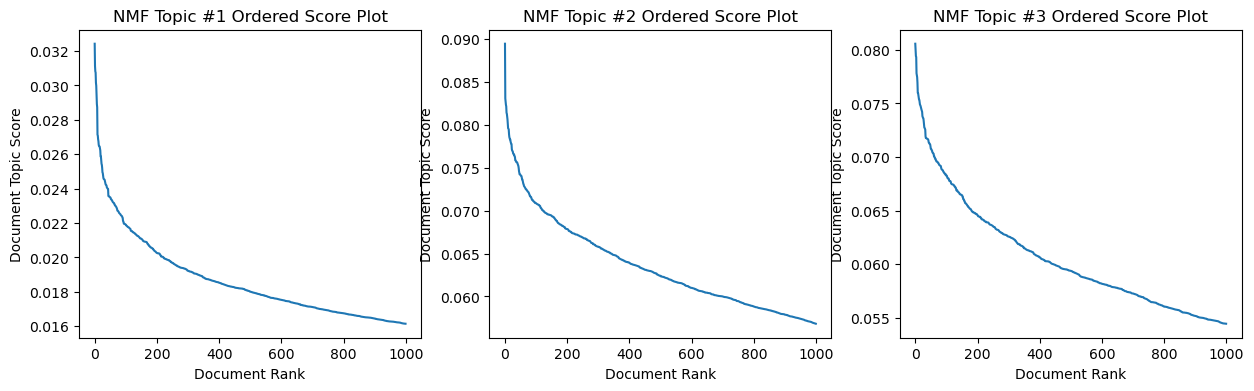

In [81]:
# NMF Topic document scores for topics 0-2
plt.figure(figsize=(15,4))
for i in range(3):
    series = pd.Series(text_nmf[:,i]).copy().sort_values(ascending = False).reset_index(drop = True)
    plt.subplot(1,3,i+1)
    plt.plot(series[:1000])
    plt.title('NMF Topic #{} Ordered Score Plot'.format(i+1))
    plt.xlabel('Document Rank')
    plt.ylabel('Document Topic Score')
#plt.savefig('DocsByTop_Score_Elbows.png', transparent = True)
plt.show()

While this method has not been previously utilized, the plots above take  after scree plots, and they plot the scores of documents as they relate to their respective topics in descending order. By plotting these elbow plots, it might shed light on the best number of documents to use to rank words.

We will be using NNMF for the model because the topics seemed to have converged more distinctly on topic. According to the 'Scree Plots' corresponding to the NNMF topics, it seems that the scores begin leveling out around 200 documents. Therefore we will use TextRank on the top 200 documents for each topic.

***One Note: Go deeper into depth why you chose NNMF over LDA.***

# \~~Putting it all together~~

Reintialize the model with 'pseudo-optimized' parameters, more easily track flow of data, and toggle with parameters all in one place. The "database" will also be created so that user queries will return results in a speedy manner!

Some pieces of code will be commented out with a triple ***\''' '''*** to indicate that the code takes too long to run and should only be run when the kernel has been shutdown.

In [82]:
import pandas as pd
import numpy as np
import re
import spacy
from functools import reduce
from operator import add
import string
import re
import multiprocessing as mp

### Below is all the code necessary to clean the data into useable form for modeling.
'''
# Loading Data
allrecipes_raw = pd.read_json('../__DATA__/recipes_raw/recipes_raw_nosource_ar.json')

allrecipes = allrecipes_raw.copy().T.reset_index().drop(columns = ['index'])
recipes = pd.concat([allrecipes, epicurious, foodnetwork]).reset_index(drop=True) # Concat does not reset indices

# Cleaning
null_recs = recipes.copy().drop(columns = 'picture_link').T.isna().any()
rows_to_drop = recipes[null_recs].index
recipes = recipes.drop(index = rows_to_drop).reset_index(drop = True)

nc_ingred_index = [index for i, index in zip(recipes['ingredients'], recipes.index) if all(j.isdigit() or j in string.punctuation for j in i)]
nc_title_index = [index for i, index in zip(recipes['title'], recipes.index) if all(j.isdigit() or j in string.punctuation for j in i)]
nc_instr_index = [index for i, index in zip(recipes['instructions'], recipes.index) if all(j.isdigit() or j in string.punctuation for j in i)]

index_list = [nc_ingred_index, nc_title_index, nc_instr_index]

inds_to_drop = set(reduce(add, index_list))
print(len(inds_to_drop))
recipes = recipes.drop(index=inds_to_drop).reset_index(drop=True)
recipes.shape

empty_instr_ind = [index for i, index in zip(recipes['instructions'], recipes.index) if len(i) < 20]
recipes = recipes.drop(index = empty_instr_ind).reset_index(drop=True)

ingredients = []
for ing_list in recipes['ingredients']:
    clean_ings = [ing.replace('ADVERTISEMENT','').strip() for ing in ing_list]
    if '' in clean_ings:
        clean_ings.remove('')
    ingredients.append(clean_ings)
recipes['ingredients'] = ingredients

recipes['ingredient_text'] = ['; '.join(ingredients) for ingredients in recipes['ingredients']]
recipes['ingredient_text'].head()

recipes['ingredient_count'] = [len(ingredients) for ingredients in recipes['ingredients']]

all_text = recipes['title'] + ' ' + recipes['ingredient_text'] + ' ' + recipes['instructions']

def clean_text(documents):
    cleaned_text = []
    for doc in documents:
        doc = doc.translate(str.maketrans('', '', string.punctuation)) # Remove Punctuation
        doc = re.sub(r'\d+', '', doc) # Remove Digits
        doc = doc.replace('\n',' ') # Remove New Lines
        doc = doc.strip() # Remove Leading White Space
        doc = re.sub(' +', ' ', doc) # Remove multiple white spaces
        cleaned_text.append(doc)
    return cleaned_text

cleaned_text = clean_text(all_text)

# Testing Strategies and Code
nlp = spacy.load('en')
' '.join([token.lemma_ for token in nlp(cleaned_text[2]) if not token.is_stop])

def text_tokenizer_mp(doc):
    tok_doc = ' '.join([token.lemma_ for token in nlp(doc) if not token.is_stop])
    return tok_doc

# Parallelzing tokenizing process
pool = mp.Pool(mp.cpu_count())
tokenized_text = pool.map(text_tokenizer_mp, [doc for doc in cleaned_text])
'''

# Creating TF-IDF Matrices and recalling text dependencies

'''import text_tokenized.csv here to'''

# TF-IDF vectorizer instance
'''vectorizer = TfidfVectorizer(lowercase = True,
                            ngram_range = (1,1))'''

'''text_tfidf = vectorizer.fit_transform(tokenized_text)'''

'text_tfidf = vectorizer.fit_transform(tokenized_text)'

In [83]:
# Set All Recommendation Model Parameters
N_topics = 50             # Number of Topics to Extract from corpora
N_top_docs = 200          # Number of top documents within each topic to extract keywords
N_top_words = 25          # Number of keywords to extract from each topic
N_docs_categorized = 2000 # Number of top documents within each topic to tag 
N_neighbor_window = 4     # Length of word-radius that defines the neighborhood for
                          # each word in the TextRank adjacency table

# Query Similarity Weights
w_title = 0.2
w_text = 0.3
w_categories = 0.5
w_array = np.array([w_title, w_text, w_categories])

# Recipe Stopwords: for any high volume food recipe terminology that doesn't contribute
# to the searchability of a recipe. This list must be manually created.
recipe_stopwords = ['cup','cups','ingredient','ingredients','teaspoon','teaspoons','tablespoon',
                   'tablespoons','C','F']

In [84]:
# Renaming Data Dependencies
topic_transformed_matrix = text_nmf
root_text_data = cleaned_text

### Generating  tags (keywords/categories) and assigning to corresponding documents

In [85]:
from itertools import repeat

#recipes['tag_list'] = [[] for i in repeat(None, recipes.shape[0])]

def topic_docs_4kwsummary(topic_document_scores, root_text_data):
    '''Gathers and formats the top recipes in each topic'''
    text_index = pd.Series(topic_document_scores).sort_values(ascending = False)[:N_top_docs].index
    text_4kwsummary = pd.Series(root_text_data)[text_index]
    return text_4kwsummary

def generate_filter_kws(text_list):
    '''Filters out specific parts of speech and stop words from the list of potential keywords'''
    parsed_texts = nlp(' '.join(text_list)) 
    kw_filts = set([str(word) for word in parsed_texts 
                if (word.pos_== ('NOUN' or 'ADJ' or 'VERB'))
                and word.lemma_ not in recipe_stopwords])
    return list(kw_filts), parsed_texts

def generate_adjacency(kw_filts, parsed_texts):
    '''Tabulates counts of neighbors in the neighborhood window for each unique word'''
    adjacency = pd.DataFrame(columns=kw_filts, index=kw_filts, data = 0)
    for i, word in enumerate(parsed_texts):
        if any ([str(word) == item for item in kw_filts]):
            end = min(len(parsed_texts), i+N_neighbor_window+1) # Neighborhood Window Utilized Here
            nextwords = parsed_texts[i+1:end]
            inset = [str(x) in kw_filts for x in nextwords]
            neighbors = [str(nextwords[i]) for i in range(len(nextwords)) if inset[i]]
            if neighbors:
                adjacency.loc[str(word), neighbors] += 1
    return adjacency
                
def generate_wordranks(adjacency):
    '''Runs TextRank on adjacency table'''
    nx_words = nx.from_numpy_matrix(adjacency.values)
    ranks=nx.pagerank(nx_words, alpha=.85, tol=.00000001)
    return ranks

def generate_tag_list(ranks):
    '''Uses TextRank ranks to return actual key words for each topic in rank order'''
    rank_values = [i for i in ranks.values()]
    ranked = pd.DataFrame(zip(rank_values, list(kw_filts))).sort_values(by=0,axis=0,ascending=False)
    kw_list = ranked.iloc[:N_top_words,1].to_list()
    return kw_list

# Master Function utilizing all above functions
def generate_tags(topic_document_scores, root_text_data):
    text_4kwsummary = topic_docs_4kwsummary(topic_document_scores, root_text_data)
    kw_filts, parsed_texts = generate_filter_kws(text_4kwsummary)
    adjacency = generate_adjacency(kw_filts, parsed_texts)
    ranks = generate_wordranks(adjacency)
    kw_list = generate_tag_list(ranks)
    return kw_list

def generate_kw_index(topic_document_scores):
    kw_index = pd.Series(topic_document_scores).sort_values(ascending = False)[:N_docs_categorized].index
    return kw_index

    

In [90]:
def generate_adjacency(kw_filts, parsed_texts):
    adjacency = pd.DataFrame(columns=kw_filts, index=kw_filts, data=0)
    for i, word in enumerate(parsed_texts):
        if any([str(word) == item for item in kw_filts]):
            end = min(len(parsed_texts), i + 5)  # Window of four words
            nextwords = parsed_texts[i + 1:end]
            inset = [str(x) in kw_filts for x in nextwords]
            neighbors = [str(nextwords[i]) for i in range(len(nextwords)) if inset[i]]
            if neighbors:
                for neighbor in neighbors:
                    adjacency.loc[str(word), neighbor] += 1
    return adjacency

In [94]:
# Generating Tags and distributing to relevant documents
for i in range(topic_transformed_matrix.shape[1]):
    scores = topic_transformed_matrix[:, i]
    topic_kws = generate_tags(scores, root_text_data)
    kw_index_4df = generate_kw_index(scores)
    
    # Remove duplicates from kw_index_4df
    kw_index_4df_unique = kw_index_4df.drop_duplicates()
    
    # Iterate over unique index values and update DataFrame
    for idx in kw_index_4df_unique:
        if idx in recipes.index:
            if 'tag_list' not in recipes.columns:
                recipes['tag_list'] = ''  # Create the 'tag_list' column if it doesn't exist
            recipes.at[idx, 'tag_list'] += ', '.join(topic_kws)  # Convert list to string and concatenate
    
    if i % 10 == 0:
        print('Topic #{} Checkpoint'.format(i))

print('done!')

Topic #0 Checkpoint
Topic #10 Checkpoint
Topic #20 Checkpoint
Topic #30 Checkpoint
Topic #40 Checkpoint
done!


In [95]:
# Saving the precious dataframe so that I never have to calculate that again.
recipes.to_csv('tagged_recipes_df.csv')

In [ ]:
# Generating Tags and distributing to relevant documents
for i in range(topic_transformed_matrix.shape[1]):
    scores = topic_transformed_matrix[:, i]
    topic_kws = generate_tags(scores, root_text_data)
    kw_index_4df = generate_kw_index(scores)
    
    # Iterate over unique index values and update DataFrame
    for idx in kw_index_4df:
        if idx in recipes.index:
            if 'tag_list' not in recipes.columns:
                recipes['tag_list'] = ''  # Create the 'tag_list' column if it doesn't exist
            recipes.at[idx, 'tag_list'] = ', '.join([recipes.at[idx, 'tag_list']] + topic_kws)  # Concatenate strings
    
    if i % 10 == 0:
        print('Topic #{} Checkpoint'.format(i))

print('done!')


Topic #0 Checkpoint


In [ ]:
recipes.loc[:5,'tag_list']

In [ ]:
# Concatenating lists of tags into a string a collective of tags for each documents
recipes['tags'] = [' '.join(tags) for tags in recipes['tag_list']]

In [ ]:
recipes.loc[:5,'tags']

### Querying Algorithm
The final product presented is a search algorithm that takes in a list of ingredients or categories, and uses the query to return relavant recipes that utilize those ingredients or are similarly related to other ingredients and those recipes.

In [ ]:
recipes.columns

In [ ]:
# Creating TF-IDF Matrices and recalling text dependencies

'''import text_tokenized.csv here'''

# TF-IDF vectorizer instance
'''vectorizer = TfidfVectorizer(lowercase = True,
                            ngram_range = (1,1))'''

'''text_tfidf = vectorizer.fit_transform(tokenized_text)'''
# title_tfidf = vectorizer.transform(recipes['title'])
# text_tfidf    <== Variable with recipe ingredients and instructions
# tags_tfidf = vectorizer.transform(recipes['tags'])
# recipes   <== DataFrame; For indexing and printing recipes

# Query Similarity Weights
w_title = .2
w_text = .3
w_categories = .5


In [ ]:
def qweight_array(query_length, qw_array = [1]):
    '''Returns descending weights for ranked query ingredients'''
    if query_length > 1:
        to_split = qw_array.pop()
        split = to_split/2
        qw_array.extend([split, split])
        return qweight_array(query_length - 1, qw_array)
    else:
        return np.array(qw_array)

def ranked_query(query):
    '''Called if query ingredients are ranked in order of importance.
    Weights and adds each ranked query ingredient vector.'''
    query = [[q] for q in query]      # place words in seperate documents
    q_vecs = [vectorizer.transform(q) for q in query] 
    qw_array = qweight_array(len(query),[1])
    q_weighted_vecs = q_vecs * qw_array
    q_final_vector = reduce(np.add,q_weighted_vecs)
    return q_final_vector

def overall_scores(query_vector):
    '''Calculates Query Similarity Scores against recipe title, instructions, and keywords.
    Then returns weighted averages of similarities for each recipe.'''
    final_scores = title_tfidf*query_vector.T*w_title
    final_scores += text_tfidf*query_vector.T*w_text
    final_scores += tags_tfidf*query_vector.T*w_categories
    return final_scores

def print_recipes(index, query, recipe_range):
    '''Prints recipes according to query similary ranks'''
    print('Search Query: {}\n'.format(query))
    for i, index in enumerate(index, recipe_range[0]):
        print('Recipe Rank: {}\t'.format(i+1),recipes.loc[index, 'title'],'\n')
        print('Ingredients:\n{}\n '.format(recipes.loc[index, 'ingredient_text']))
        print('Instructions:\n{}\n'.format(recipes.loc[index, 'instructions']))
        
def Search_Recipes(query, query_ranked=False, recipe_range=(0,3)):
    '''Master Recipe Search Function'''
    if query_ranked == True:
        q_vector = ranked_query(query)
    else:
        q_vector = vectorizer.transform([' '.join(query)])
    recipe_scores = overall_scores(q_vector)
    sorted_index = pd.Series(recipe_scores.toarray().T[0]).sort_values(ascending = False)[recipe_range[0]:recipe_range[1]].index
    return print_recipes(sorted_index, query, recipe_range)
    

### Testing the Algorithm

In [ ]:
query = ['cinnamon', 'cream', 'banana']
Search_Recipes(query, query_ranked=True, recipe_range=(0,3))

In [ ]:
# Test Rank
query = ['wine', 'cilantro','butter']
Search_Recipes(query, query_ranked=False, recipe_range=(0,3))

### -- Conclusions and Model Outlook --

Overall the Search_Recipes function works quite well. From experimenting with the weighting, it's clear to me that the original text of the recipes returns better results than the categories generated with TextRank. More topics need to be added; from looking at the food topic documents, it's clear that the level of granularity with which LDA and NNMF can cluster recipe is very good. Another fix for this issue is to utilize dense word embeddings that capture semantic similarities between words with more sophistication. THe biggest issue with the current model is that the words that maps to each topics or category are limited and discreet. Even if a a words is technically more related to a topic than the words extracted from the same topic, yet the word was not extracted from the topic, then the original word query won't be factored into the search through the categories.

Also it does appear that some words are more heavily weighted than others, which biases the search results towards that ingredient, although this does require more rigorous texting. "Miso" is a word that is heavily weighted in the tfidf matrices for example. One work around is to use simple rank this ingredient lower in the Search_Recipes function, but a global solution is preferable. It is perhaps more beneficial to utilize these weights that tf-idf creates, rather than finding a way to get rid of them. But experimenting with different word embeddings would be interesting.

Also, another issue is that many recipes were not assigned categories due to the model parameters, and this decreases there ranks with the text with an unfair disadvantage. Hopefully a future iteration of this model will allow all recipes to have associated categories.

Future Implementation and Changes for this model:

- Word2Vec or GloVe embeddings
- LDA2Vec topic extraction
- Negative Querying that decreases rank of matching queries
- Using real databases to store data and creating a creating an user interface on which this model where this model can be easily utilized



In [ ]:
# Test 
query = ['jelly','wine']
Search_Recipes(query, query_ranked=False, recipe_range=(0,3))

In [ ]:
query = ['pepper','apple','pork']
Search_Recipes(query, query_ranked=False, recipe_range=(0,3))

In [ ]:
recipes['tags'][122894]

--------
### Some notes:
List of Parameters and Evaluation Methods
- Number of Topics
- Number of Documents to pull keywords from
- Number of Keywords per topic
- Number of Documents to assign keywords to
- Neighbor Window Size
- Query Title Weight
- Query Description Weight
- Query Category Weight

In [ ]:
### No Category Weight
query = ['cream','banana','cinnamon']
Search_Recipes(query, query_ranked=False, recipe_range=(0,3))

In [ ]:
### Empty Query
query = []
Search_Recipes(query, query_ranked=False, recipe_range=(0,3))

In [ ]:
### Only Category Weight
query = ['apple','blueberry']
Search_Recipes(query, query_ranked=False, recipe_range=(0,3))

In [ ]:
### Only Category Weight
query = ['japanese']
Search_Recipes(query, query_ranked=False, recipe_range=(0,3))

Further Analysis:
- Generate Tag Count column in the Recipes data frame. Analyze distribution of tags.
- See if all of the topics are easily interpretable from the generated tags.

### Peerings into the generated topics

In [ ]:
recipes.tags

In [ ]:
recipes.tags[13]

In [ ]:
recipes.tags[122907]

In [ ]:
recipes.tags[90708]

In [ ]:
recipes.tags[50409]

In [ ]:
recipes.tags[30234]

In [ ]:
recipes.tags[23596]

In [ ]:
recipes.tags[60457]

In [ ]:
recipes.tags[110997]

In [ ]:
recipes.head()